In [ ]:
!pip install pyspark

### ⛳ Getting the data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### ▶ Loading the data and showing the first 10

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

# Start Spark session
spark = SparkSession.builder.appName("Salary Analysis").getOrCreate()

# Define file paths
path_2012 = '/content/drive/MyDrive/Colab Notebooks/brazil_salaries_data/2012_merged.csv'
path_2013 = '/content/drive/MyDrive/Colab Notebooks/brazil_salaries_data/2013_merged.csv'

# Read CSVs using the correct semicolon separator
df_2012 = spark.read.csv(path_2012, header=True, inferSchema=True, sep=';')
df_2013 = spark.read.csv(path_2013, header=True, inferSchema=True, sep=';')

# Optional: Add year column to each
df_2012 = df_2012.withColumn("YEAR", lit(2012))
df_2013 = df_2013.withColumn("YEAR", lit(2013))

# Merge datasets
combined_df = df_2012.unionByName(df_2013)

# Show result
combined_df.show(10)


+--------------------+--------------------+-----------+-----------+---------+--------------------+------+----+
|                NAME|          DEPARTMENT|MONTH_TOTAL|GROSS_TOTAL|NET_TOTAL|            POSITION| MONTH|YEAR|
+--------------------+--------------------+-----------+-----------+---------+--------------------+------+----+
|AAIRON TELES DE C...|   SEGURANCA PUBLICA|    1196,63|    1196,63|   720,66|OFICIAL ADMINISTR...|AUGUST|2012|
|AARAN ESTEVAO LIM...|POLICIA MILITAR E...|    5445,61|    7092,66|  5054,20|            2TEN  PM|AUGUST|2012|
|   AARAO DE OLIVEIRA|POLICIA MILITAR E...|   11344,51|   11344,51|  6451,63|            MAJ   PM|AUGUST|2012|
|AARON DE OLIVEIRA...|HOSPITAL DAS CLIN...|    4024,46|    4024,46|  3386,58|AGENTE TECNICO AS...|AUGUST|2012|
|AARON GABRIEL MIR...|SAO PAULO PREVIDE...|    1189,26|    2212,06|  2212,06|BENEFICIARIO DE S...|AUGUST|2012|
|AARON LUCAS MOLIN...|POLICIA MILITAR E...|    2597,90|    2597,90|  2293,59|            SD 2C PM|AUGUST|2012|
|

### ⚓ Importin the functions and methods we will use throught this file

In [ ]:
from pyspark.sql.functions import regexp_replace, col, avg, desc, round, count

### 🍃 Cleaning the data from string to number

In [ ]:
# Clean and convert GROSS_TOTAL and NET_TOTAL from string to double
combined_df = combined_df.withColumn("GROSS_TOTAL", regexp_replace("GROSS_TOTAL", "[.]", ""))
combined_df = combined_df.withColumn("GROSS_TOTAL", regexp_replace("GROSS_TOTAL", ",", ".").cast("double"))

combined_df = combined_df.withColumn("NET_TOTAL", regexp_replace("NET_TOTAL", "[.]", ""))
combined_df = combined_df.withColumn("NET_TOTAL", regexp_replace("NET_TOTAL", ",", ".").cast("double"))

In [ ]:
combined_df.show(10)

+--------------------+--------------------+-----------+-----------+---------+--------------------+------+----+
|                NAME|          DEPARTMENT|MONTH_TOTAL|GROSS_TOTAL|NET_TOTAL|            POSITION| MONTH|YEAR|
+--------------------+--------------------+-----------+-----------+---------+--------------------+------+----+
|AAIRON TELES DE C...|   SEGURANCA PUBLICA|    1196,63|    1196.63|   720.66|OFICIAL ADMINISTR...|AUGUST|2012|
|AARAN ESTEVAO LIM...|POLICIA MILITAR E...|    5445,61|    7092.66|   5054.2|            2TEN  PM|AUGUST|2012|
|   AARAO DE OLIVEIRA|POLICIA MILITAR E...|   11344,51|   11344.51|  6451.63|            MAJ   PM|AUGUST|2012|
|AARON DE OLIVEIRA...|HOSPITAL DAS CLIN...|    4024,46|    4024.46|  3386.58|AGENTE TECNICO AS...|AUGUST|2012|
|AARON GABRIEL MIR...|SAO PAULO PREVIDE...|    1189,26|    2212.06|  2212.06|BENEFICIARIO DE S...|AUGUST|2012|
|AARON LUCAS MOLIN...|POLICIA MILITAR E...|    2597,90|     2597.9|  2293.59|            SD 2C PM|AUGUST|2012|
|

### 🔍 Step 4: Data Exploration & Validation

Before proceeding with analysis, we'll:
- Check for nulls in key columns
- Print schema and row/column counts
- Get descriptive statistics\

In [ ]:
# Show schema
combined_df.printSchema()

# Count rows and columns
print(f"Rows: {combined_df.count()}, Columns: {len(combined_df.columns)}")

# Check for nulls
for col_name in ["GROSS_TOTAL", "NET_TOTAL", "MONTH_TOTAL", "DEPARTMENT"]:
    print(f"Nulls in {col_name}: {combined_df.filter(col(col_name).isNull()).count()}")

# Get descriptive statistics
combined_df.select("GROSS_TOTAL", "NET_TOTAL", "MONTH_TOTAL").describe().show()

root
 |-- NAME: string (nullable = true)
 |-- DEPARTMENT: string (nullable = true)
 |-- MONTH_TOTAL: string (nullable = true)
 |-- GROSS_TOTAL: double (nullable = true)
 |-- NET_TOTAL: double (nullable = true)
 |-- POSITION: string (nullable = true)
 |-- MONTH: string (nullable = true)
 |-- YEAR: integer (nullable = false)

Rows: 19015593, Columns: 8
Nulls in GROSS_TOTAL: 0
Nulls in NET_TOTAL: 0
Nulls in MONTH_TOTAL: 0
Nulls in DEPARTMENT: 0
+-------+-----------------+------------------+-----------+
|summary|      GROSS_TOTAL|         NET_TOTAL|MONTH_TOTAL|
+-------+-----------------+------------------+-----------+
|  count|         19015593|          19015593|   19015593|
|   mean|3649.000084899573| 2718.100144756588|       NULL|
| stddev| 4030.68498600406|2773.0737315030633|       NULL|
|    min|        -93317.11|           -502.81|        ,00|
|    max|        879388.75|          399898.8|    9999,96|
+-------+-----------------+------------------+-----------+



### 💸 Gross vs Net Salary: Calculating Deductions

To understand the disparity between gross and net salaries, we create a new column called `DEDUCTIONS`, which represents how much was taken out of an employee’s gross pay. This helps us analyze whether some individuals face higher deductions than others, and explore general trends in take-home pay across the dataset.

In [ ]:
# get the deductions
df_deductions = combined_df.withColumn("DEDUCTIONS", round(col("GROSS_TOTAL") - col("NET_TOTAL"), 2))

# 🔍 Display selected salary-related fields
df_deductions.select("NAME", "GROSS_TOTAL", "DEDUCTIONS", "NET_TOTAL").show(10)


+--------------------+-----------+----------+---------+
|                NAME|GROSS_TOTAL|DEDUCTIONS|NET_TOTAL|
+--------------------+-----------+----------+---------+
|AAIRON TELES DE C...|    1196.63|    475.97|   720.66|
|AARAN ESTEVAO LIM...|    7092.66|   2038.46|   5054.2|
|   AARAO DE OLIVEIRA|   11344.51|   4892.88|  6451.63|
|AARON DE OLIVEIRA...|    4024.46|    637.88|  3386.58|
|AARON GABRIEL MIR...|    2212.06|       0.0|  2212.06|
|AARON LUCAS MOLIN...|     2597.9|    304.31|  2293.59|
|   AARON MARQUES FRE|    2792.08|    444.25|  2347.83|
|AARON SALES DE AL...|    2919.03|    618.43|   2300.6|
|ABADE OLIVEIRA SOUZA|    2887.47|     57.74|  2829.73|
|ABADIA ALMEIDA CO...|    2283.57|   1454.06|   829.51|
+--------------------+-----------+----------+---------+
only showing top 10 rows



### 📉 Top 10 Employees with Highest Deductions

This analysis displays the top 10 employees who had the highest difference between gross and net salaries.

- Highlights individuals most affected by deductions
- Useful for investigating potential causes such as taxes, benefits, or position-specific withholdings
- May reveal trends related to specific departments

In [ ]:
# top 10 employees with highest deductions
df_emp_deductions = df_deductions.orderBy(desc("DEDUCTIONS")).limit(10)

df_emp_deductions.select("NAME", "DEPARTMENT", "DEDUCTIONS").show()

+--------------------+--------------------+----------+
|                NAME|          DEPARTMENT|DEDUCTIONS|
+--------------------+--------------------+----------+
|MARIA LOURDES M S...|ADMINISTRACAO GER...| 826374.49|
|   AMILTON FERNANDES|ADMINISTRACAO GER...| 779447.44|
|APARECIDA GRATAGL...|ADMINISTRACAO GER...| 762266.78|
|FRANCISCO RAIA DA...|ADMINISTRACAO GER...| 759368.23|
| NEUSA ANSELMO SIMON|ADMINISTRACAO GER...| 721400.01|
|CARLOS JOSE LOCOS...|ADMINISTRACAO GER...| 634164.62|
|OSVALDO PATROCINI...|ADMINISTRACAO GER...| 609531.33|
|FREDERICO ADELCHI...|ADMINISTRACAO GER...| 600716.04|
|     DJALMIR MARIANO|ADMINISTRACAO GER...| 595772.16|
|ALBERTO ANTONIO T...|ADMINISTRACAO GER...| 591022.57|
+--------------------+--------------------+----------+



### 🏢 Average Salaries by Department

This analysis identifies which departments have the highest average gross and net salaries across employees.

The goal is to:

- Compare average **gross** vs. **net** salaries per department  
- Observe which departments pay more on average  
- Explore how deductions might affect departments differently  

We display only the **top 10 departments** by average gross salary.


In [ ]:
df_dept = combined_df.groupBy("DEPARTMENT").agg(
    round(avg("GROSS_TOTAL"), 2).alias("avg_gross"),
    round(avg("NET_TOTAL"), 2).alias("avg_net")
).limit(10)

df_dept.select("DEPARTMENT", "avg_gross", "avg_net").show()
# Gotta go to sleep, tomorrow have passport appointment ;(

+--------------------+---------+-------+
|          DEPARTMENT|avg_gross|avg_net|
+--------------------+---------+-------+
|ADMINISTRACAO GER...|   3689.0|1553.38|
|INST.ASSIST.MEDIC...|  4179.68|2981.63|
|AGENCIA METROPOLI...|  7391.54|5704.38|
|INST MEDICINA SOC...|  4814.36|3863.84|
|COMPANHIA PAUL. E...|  5457.43|4779.19|
|FUND.DESENV. ADMI...|  7811.84|5175.79|
|FUND.ONCOCENTRO D...|  4690.18|3200.24|
|               SAUDE|  3416.32|2605.81|
|CENTRO EDUC. TECN...|  3581.93| 2688.0|
|FUNDACAO PARQUE Z...|  2472.98|1900.57|
+--------------------+---------+-------+



## 🧮 Deduction Percentage per Employee

In this step, we calculate the **percentage of salary deducted** for each employee by comparing their gross and net salaries.

We ensure data integrity by:
- Filtering out invalid rows where net salary exceeds gross salary or any value is zero/negative.
- Creating a new column for absolute deduction.
- Calculating the percentage of deductions relative to gross salary.

The table below displays the **top 10 employees with the highest deduction percentages**.


In [ ]:
# Aggregate by employee name, calculating the average of each salary-related field
df_avg_deductions = df_deductions.groupBy("NAME").agg(
    avg("GROSS_TOTAL").alias("avg_gross"),
    avg("NET_TOTAL").alias("avg_net"),
    avg("DEDUCTIONS").alias("avg_deductions"),
    avg("DEDUCTION_PERCENTAGE").alias("avg_deduction_percentage")
)

# Show top employees with highest average deduction percentages
df_avg_deductions.select(
    "NAME",
    round(col("avg_gross"), 2).alias("avg_gross"),
    round(col("avg_net"), 2).alias("avg_net"),
    round(col("avg_deductions"), 2).alias("avg_deductions"),
    round(col("avg_deduction_percentage"), 2).alias("avg_deduction_percentage")
).orderBy(col("avg_deduction_percentage").desc()) \
 .show(truncate=False)

+------------------------------+---------+-------+--------------+------------------------+
|NAME                          |avg_gross|avg_net|avg_deductions|avg_deduction_percentage|
+------------------------------+---------+-------+--------------+------------------------+
|EUNICE DE ALMEIDA DE ASSIS    |1253.55  |1.37   |1252.18       |99.89                   |
|AURELIO GONCALVES LUMINATTI   |1896.66  |2.15   |1894.51       |99.89                   |
|NAIR FORTUNA DO ROSARIO       |1326.58  |1.58   |1325.0        |99.88                   |
|PORFIRIA DE FARIA ROLIN       |1326.58  |1.58   |1325.0        |99.88                   |
|AUREA DE MOURA LAURA          |3979.74  |4.74   |3975.0        |99.88                   |
|ALICE ALVES DE OLIVEIRA       |1326.58  |1.58   |1325.0        |99.88                   |
|MARIA CORDEIRO CONSTANTINO    |1989.87  |2.37   |1987.5        |99.88                   |
|CATHARINA CARRERI             |2737.16  |3.76   |2733.4        |99.86                   |

📊 **Deduction Percentage Distribution (Boxplot)**

To better understand how salary deductions are distributed across employees, we visualize the average deduction percentages using a boxplot.

This approach helps us:

- Identify the typical deduction range (IQR),
- Detect high outliers (e.g., deductions close to 100%),
- Understand the shape of the overall distribution.

⚠️ Since the dataset is large and heavily skewed, we apply:
- A sampling limit (2000 rows max),
- An upper cutoff to exclude extreme values (> 80%).

This ensures the plot remains interpretable and computationally light.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

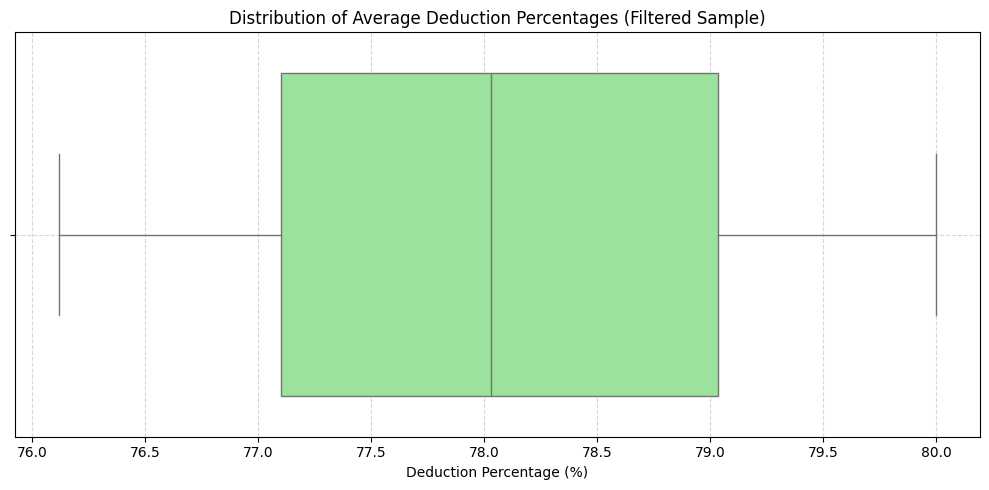

In [ ]:
# ⚠️ Filter and limit inside Spark to keep the load light and meaningful
sample_df = df_avg_deductions.filter(
    (col("avg_deduction_percentage") <= 80)  # Exclude extreme outliers
).orderBy(col("avg_deduction_percentage").desc()) \
 .limit(2000)  # Max 2000 rows is enough for clear visualization

# ✅ Convert to Pandas
pdf = sample_df.toPandas()

# 📊 Plot the boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=pdf["avg_deduction_percentage"], color="lightgreen")

plt.title("Distribution of Average Deduction Percentages (Filtered Sample)")
plt.xlabel("Deduction Percentage (%)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### 📊 Average Net Salaries by Department (2012 vs 2013)

This section presents a comparative bar chart showing the **average net salaries** across departments for the years **2012** and **2013**.

#### What this analysis reveals:

- 📈 Departments where net salaries increased or decreased over the years  
- 🏢 Departments with consistently high or low average pay  
- 🔍 Disparities and shifts in salary distribution between the two periods  

To maintain clarity, we selected the **top 12 departments (based on average salary in 2012)**. This helps us focus on the most relevant changes without overcrowding the visualization.


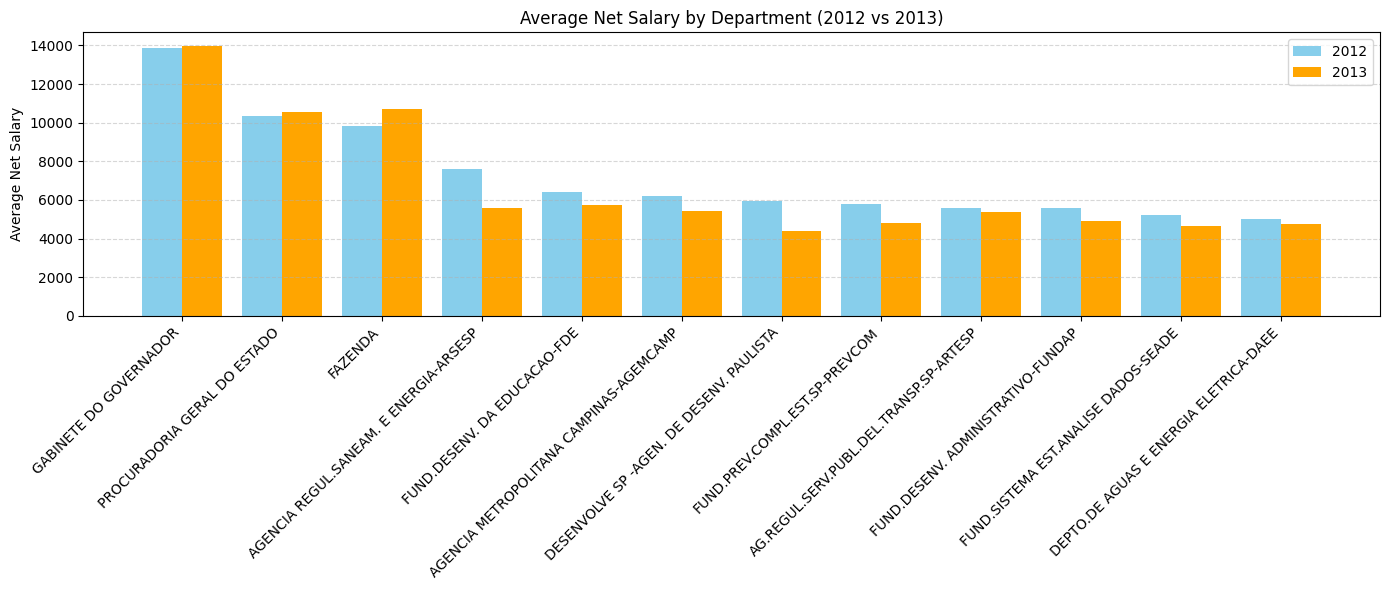

In [ ]:
# Filter by year
df_2012 = combined_df.filter(col("YEAR") == 2012)
df_2013 = combined_df.filter(col("YEAR") == 2013)

# Group by department and calculate average net salary
avg_2012 = df_2012.groupBy("DEPARTMENT").agg(avg("NET_TOTAL").alias("avg_net_2012"))
avg_2013 = df_2013.groupBy("DEPARTMENT").agg(avg("NET_TOTAL").alias("avg_net_2013"))

# Join results
avg_joined = avg_2012.join(avg_2013, on="DEPARTMENT", how="inner")

# Convert to pandas (with a limit to avoid explosion)
pdf = avg_joined.orderBy("avg_net_2012", ascending=False).limit(12).toPandas()

# Plot
x = range(len(pdf))
width = 0.4

plt.figure(figsize=(14, 6))
plt.bar([i - width/2 for i in x], pdf["avg_net_2012"], width=width, label="2012", color="skyblue")
plt.bar([i + width/2 for i in x], pdf["avg_net_2013"], width=width, label="2013", color="orange")

plt.xticks(x, pdf["DEPARTMENT"], rotation=45, ha="right")
plt.ylabel("Average Net Salary")
plt.title("Average Net Salary by Department (2012 vs 2013)")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.show()
